<div class="usecase-title">Urban Design and Physical Activity</div>
<div class="usecase-authors">Author: Nidhi Kanchepalle</div>

<div class="usecase-level-skill">
    <div class="usecase-level">Level: Intermediate</div>
    <div class="usecase-skill">Skills: Python, Exploratory Data Analysis, Data Visualisation</div>
</div>

<div class="usecase-duration">Duration: {90} minutes</div>

---

<div class="usecase-section-header">Scenario</div>

This use case explores how urban design influences physical activity across Melbourne by analysing open datasets on pedestrian counts, footpaths, playgrounds, residential profiles, building footprints, and suburb boundaries. The objective is to uncover spatial and temporal patterns in pedestrian movement and examine how various elements of the built environment contribute to walking behaviour. The pedestrian counts data spans from 2023 to 2025, providing a recent view of foot traffic trends across the city. By integrating geospatial and demographic data—including building footprints that reveal density, height, and structure types—the analysis aims to identify suburbs that promote higher levels of physical activity and understand the role of infrastructure—such as well-connected footpaths, access to recreational areas, and population distribution—in shaping these trends. The insights derived from this study can help urban planners make informed, evidence-based decisions to design healthier, more walkable neighbourhoods that encourage active lifestyles.

---

<div class="usecase-section-header">What This Use Case Will Teach You</div>

At the end of this use case, you will be able to:
- Learn how to load data using APIs
- Handle missing values and prepare the data for meaningful analysis
- Use grouping, filtering, and aggregation techniques to uncover patterns and trends
- Perform spatial joins and analyse geospatial data using GeoPandas
- Visualise temporal and spatial trends using appropriate charts and maps
- Identify correlations between infrastructure features and pedestrian activity
- Generate actionable insights to inform urban planning decisions


<div class="usecase-section-header">Background / Introduction</div>

Urban planning plays a crucial role in shaping how people interact with their surroundings, especially when it comes to promoting active lifestyles. Walkable neighbourhoods with accessible footpaths, green spaces, and recreational areas are more likely to encourage residents to engage in physical activity. As cities grow, there is a growing need for data-driven approaches to understand how urban design influences movement patterns and community well-being.

This use case aims to explore the relationship between urban infrastructure and physical activity levels, using pedestrian count data. By integrating multiple open datasets—such as pedestrian count data, footpath networks, playground locations, building footprints, suburb boundaries, and demographic profiles—we aim to uncover trends and spatial patterns that highlight how the built environment impacts walking behaviour.

Through this analysis, urban planners and decision-makers can gain insights into which areas support active lifestyles and where improvements in infrastructure could have the most impact. The ultimate goal is to use data to inform more effective urban design strategies that prioritise health, accessibility, and sustainability across Melbourne's suburbs.



In [1]:
import pandas as pd
from io import StringIO
from shapely.geometry import Point
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from io import BytesIO
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import folium
from folium.plugins import HeatMap
from sklearn.cluster import KMeans


##  Importing Data Through API

In [4]:

with open("API_Key.txt", "r", encoding="utf-8-sig") as f:
    API_KEY = f.read().strip()

# Define API data fetching function
def API_upload(dataset_key):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    format = 'csv'
    full_url = f'{base_url}{dataset_key}/exports/{format}'

    params = {
        'select': '*',
        'timezone': 'UTC',
        'lang': 'en',
        'limit': '-1'
    }

    headers = {
        'X-App-Token': API_KEY
    }

    response = requests.get(full_url, params=params, headers=headers)
    if response.status_code == 200:
        content = response.content.decode('utf-8')
        df = pd.read_csv(StringIO(content), delimiter=';')
        df['SOURCE_DATASET'] = dataset_key
        return df
    else:
        print(f"Error fetching data from {full_url}: {response.status_code}")
        return pd.DataFrame()

data_sets = {
    "pedestrian_counts": ['pedestrian-counting-system-monthly-counts-per-hour'],
    "building_footprints": ['2023-building-footprints'],
    "playgrounds": ['playgrounds'],
    "footpaths": ['footpaths'],
    "resident_profiles": ['residents-profiles-by-clue-small-area']
}

pedestrian_counts_df = pd.concat([API_upload(ds) for ds in data_sets["pedestrian_counts"]], ignore_index=True)
building_footprints_df = pd.concat([API_upload(ds) for ds in data_sets["building_footprints"]], ignore_index=True)
playgrounds_df = pd.concat([API_upload(ds) for ds in data_sets["playgrounds"]], ignore_index=True)
footpaths_df = pd.concat([API_upload(ds) for ds in data_sets["footpaths"]], ignore_index=True)
resident_profiles_df = pd.concat([API_upload(ds) for ds in data_sets["resident_profiles"]], ignore_index=True)


In [5]:

url = "https://opendata.maps.vic.gov.au/geoserver/wfs?service=WFS&version=2.0.0&request=GetFeature&typeName=open-data-platform:locality_polygon&outputFormat=application/json&srsName=EPSG:4326&count=5000"

response = requests.get(url, verify=False)

localities_df = gpd.read_file(BytesIO(response.content))

##  Inspecting Data

The pedestrian counts dataset contains hourly foot traffic data recorded by sensors installed at various locations across Melbourne. Each entry includes the date, hour, sensor location, counts in both directions, and total pedestrian activity. This data is useful for identifying spatial and temporal trends in pedestrian movement, such as peak walking hours or high-traffic areas.

In [6]:
print("\nPedestrian Count Dataset Shape:", pedestrian_counts_df.shape)
print(pedestrian_counts_df.head())


Pedestrian Count Dataset Shape: (1387730, 10)
             id  location_id sensing_date  hourday  direction_1  direction_2  \
0  841020250213           84   2025-02-13       10          708          540   
1  701320250212           70   2025-02-12       13          145          152   
2   75020240421           75   2024-04-21        0           10           20   
3  751020240810           75   2024-08-10       10           47           44   
4    8220240916            8   2024-09-16        2            2            3   

   pedestriancount sensor_name                    location  \
0             1248      ElFi_T  -37.81798049, 144.96503383   
1              297   Errol20_T  -37.80456984, 144.94946228   
2               30    SprFli_T  -37.81515276, 144.97467661   
3               91    SprFli_T  -37.81515276, 144.97467661   
4                5     WebBN_T   -37.82293543, 144.9471751   

                                      SOURCE_DATASET  
0  pedestrian-counting-system-monthly-counts

In [7]:
start_date = pedestrian_counts_df['sensing_date'].min()
end_date = pedestrian_counts_df['sensing_date'].max()
print(start_date)
print(end_date)

2023-08-08
2025-08-07


The building footprints dataset contains spatial and structural details of buildings in Melbourne, including location, roof type, elevation, and building height. It helps in understanding building density and structure, which is useful for analysing how the built environment influences pedestrian movement and urban walkability. In this analysis, it supports a broader understanding of how urban design relates to pedestrian activity within the timeframe of 2023 to 2025.

In [8]:
print("\nBuilding Footprints Dataset Shape:", building_footprints_df.shape)
print(building_footprints_df.head())


Building Footprints Dataset Shape: (41701, 14)
                              geo_point_2d  \
0   -37.80003539659138, 144.95673941735046   
1    -37.84308942324178, 144.9077552355766   
2        -37.832043207400005, 144.97921111   
3  -37.804107867267376, 144.96814513518797   
4  -37.820196601484255, 144.94134917503217   

                                           geo_shape  objectid  structure_id  \
0  {"coordinates": [[[144.9567226597, -37.8000656...     20012        815949   
1  {"coordinates": [[[144.9078005567, -37.8431403...     20027        804149   
2  {"coordinates": [[[144.9792485137, -37.8320547...     20048        815174   
3  {"coordinates": [[[144.9682045375, -37.8040924...     20053        811834   
4  {"coordinates": [[[144.9412080937, -37.8203657...     20168        806726   

  footprint_type roof_type  footprint_max_elevation  footprint_min_elevation  \
0      Structure      Flat                     97.5                     91.5   
1      Structure      Flat        

In [9]:
print("\nPlaygrounds Dataset Shape:", playgrounds_df.shape)
print(playgrounds_df.head())


Playgrounds Dataset Shape: (45, 7)
                             geo_point_2d  \
0   -37.80284131718294, 144.9626564799592   
1   -37.8095257090171, 144.95471867901864   
2  -37.82307176194582, 144.94158310181788   
3  -37.79520740161526, 144.96970314493564   
4   -37.79616817586979, 144.9267597762389   

                                           geo_shape  council_re  \
0  {"coordinates": [[[[144.962585326539, -37.8028...     1450819   
1  {"coordinates": [[[[144.95476596702, -37.80945...     1719660   
2  {"coordinates": [[[[144.941286023475, -37.8230...     1590516   
3  {"coordinates": [[[[144.969754004322, -37.7951...     1603370   
4  {"coordinates": [[[[144.926747982283, -37.7961...     1554261   

                                            features location_d  \
0  Swings, spinners, double slide, public toilet,...        NaN   
1  Sandpit with diggers, spiral slide, swings, sa...        NaN   
2  Bells, Musical Wall, Sand pit, Swing, Carousel...        NaN   
3               

The footpaths dataset contains geospatial information about public footpaths across Melbourne, including their location, geometry, asset classification, and source of data collection. Each record represents a footpath segment and includes attributes like road segment ID, mapping method, and asset condition. This dataset is useful for measuring walkability, identifying areas with greater footpath access, and supporting urban planning decisions aimed at improving pedestrian connectivity and infrastructure.

In [10]:
print("\nFootpaths Dataset Shape:", footpaths_df.shape)
print(footpaths_df.head())


Footpaths Dataset Shape: (12222, 28)
                              geo_point_2d  \
0  -37.815961080824124, 144.98832531320022   
1    -37.8085534639264, 144.97639258466387   
2   -37.82277605089236, 144.93916171174936   
3    -37.82928417509253, 144.9694946357787   
4   -37.791735093497834, 144.9356096446368   

                                           geo_shape  prop_id name  \
0  {"coordinates": [[[[144.98810598819998, -37.81...        0  NaN   
1  {"coordinates": [[[[144.9763062409881, -37.808...        0  NaN   
2  {"coordinates": [[[[144.93917482139165, -37.82...        0  NaN   
3  {"coordinates": [[[[144.9703584145747, -37.829...        0  NaN   
4  {"coordinates": [[[[144.93560472908098, -37.79...        0  NaN   

   shape_stle  addresspt1      xorg          ext_id asset_clas label  ...  \
0  105.419673         0.0  RapidMap   RPSP0411679L1       Road   NaN  ...   
1   98.491585         0.0  RapidMap   RPSP0412168L1       Road   NaN  ...   
2    8.048221         0.0  RapidM

The resident profiles dataset provides suburb-level demographic and housing information across Melbourne, including dwelling types, household structures, and population counts. It helps in understanding community characteristics and supports analysis of how residential patterns relate to walkability and urban design

In [11]:
print("\nResident Profiles Dataset Shape:", resident_profiles_df.shape)
print(resident_profiles_df.head())


Resident Profiles Dataset Shape: (10776, 8)
           geography  year                  topic                  category  \
0          Docklands  2011  Households: Dwellings  Dwelling type - detailed   
1     East Melbourne  2011  Households: Dwellings  Dwelling type - detailed   
2  Greater Melbourne  2011  Households: Dwellings  Dwelling type - detailed   
3    Melbourne (CBD)  2011  Households: Dwellings  Dwelling type - detailed   
4          Parkville  2011  Households: Dwellings  Dwelling type - detailed   

                                        sub_category  \
0        Flat or apartment - In a three storey block   
1  Semi-detached, row or terrace house, townhouse...   
2            Flat or apartment - Attached to a house   
3       Other dwelling - Caravan, cabin or houseboat   
4                      Dwelling structure not stated   

                     value_description   value  \
0  Count of occupied private dwellings     0.0   
1  Count of occupied private dwellings   11

The localities dataset contains geographic boundary data for suburbs and towns across Victoria, including locality names, gazetted names, unique identifiers, and polygon geometries. It is useful for spatial analysis, such as mapping other datasets to specific suburbs or joining with demographic and infrastructure data for area-based insights

In [12]:
print("\nLocalities Dataset Shape:", localities_df.shape)
print(localities_df.head())


Localities Dataset Shape: (2973, 12)
                      id        ufi        pfi    locality_name  \
0  locality_polygon.3903  831486758  205409448      MOLLONGGHIP   
1  locality_polygon.3904  831486747  205409756  NORTH BLACKWOOD   
2  locality_polygon.3905  831486715  205410021           BASALT   
3  locality_polygon.4029  835229245  205408908         LLANELLY   
4     locality_polygon.5  468964855  205409589    MURRABIT WEST   

  gazetted_locality_name  vicnames_id  task_id               pfi_created  \
0            MOLLONGGHIP       102101      NaN 2005-09-27 08:06:12+00:00   
1        NORTH BLACKWOOD       102373      NaN 2005-09-27 08:06:12+00:00   
2                 BASALT       100297      NaN 2005-09-27 08:06:12+00:00   
3               LLANELLY       101863      NaN 2005-09-27 08:06:12+00:00   
4          MURRABIT WEST       102236      NaN 2005-09-27 08:06:12+00:00   

     ufi_old               ufi_created  label_use_code  \
0  802469033 2024-02-19 08:58:19+00:00      

## Deleting unwanted columns

The SOURCE_DATASET column is not required for analysis, so deleting it.

In [13]:
pedestrian_counts_df.drop(columns=['SOURCE_DATASET'], inplace=True)
building_footprints_df.drop(columns=['SOURCE_DATASET'], inplace=True)
playgrounds_df.drop(columns=['SOURCE_DATASET'], inplace=True)
footpaths_df.drop(columns=['SOURCE_DATASET'], inplace=True)
resident_profiles_df.drop(columns=['SOURCE_DATASET'], inplace=True)

## Checking for missing values

In [14]:

print("Null counts in Pedestrian Counts dataset:")
print(pedestrian_counts_df.isnull().sum())
print("\n---------------------------------------------\n")

print("Null counts in Building Footprints dataset:")
print(building_footprints_df.isnull().sum())
print("\n---------------------------------------------\n")

print("Null counts in Playgrounds dataset:")
print(playgrounds_df.isnull().sum())
print("\n---------------------------------------------\n")

print("Null counts in Footpaths dataset:")
print(footpaths_df.isnull().sum())
print("\n---------------------------------------------\n")

print("Null counts in Resident Profiles dataset:")
print(resident_profiles_df.isnull().sum())
print("\n---------------------------------------------\n")

print("Null counts in Localities dataset:")
print(localities_df.isnull().sum())
print("\n---------------------------------------------\n")


Null counts in Pedestrian Counts dataset:
id                 0
location_id        0
sensing_date       0
hourday            0
direction_1        0
direction_2        0
pedestriancount    0
sensor_name        0
location           0
dtype: int64

---------------------------------------------

Null counts in Building Footprints dataset:
geo_point_2d               0
geo_shape                  0
objectid                   0
structure_id               0
footprint_type             0
roof_type                  0
footprint_max_elevation    0
footprint_min_elevation    0
structure_max_elevation    0
structure_min_elevation    0
footprint_extrusion        0
structure_extrusion        0
date_captured              0
dtype: int64

---------------------------------------------

Null counts in Playgrounds dataset:
geo_point_2d     0
geo_shape        0
council_re       0
features         6
location_d      40
name             0
dtype: int64

---------------------------------------------

Null counts in 

## Handling Missing Values


Missing feature descriptions in the playgrounds dataset were filled with 'Unknown', and the location_d column, which had only 5 non-null values, is deleted.

In [15]:
playgrounds_df.drop(columns=['location_d'], inplace=True)

playgrounds_df['features'] = playgrounds_df['features'].fillna('Unknown')


The footpaths dataset has the highest number of missing value columns. Columns with mostly missing or irrelevant data were removed, and rows missing critical fields like str_id, asset_type, or asset_clas were dropped to retain only meaningful footpath records.

In [16]:
footpaths_df.drop(columns=['label', 'xdrawing', 'profile', 'asset_subt','name','xorg', 'xsource', 'ext_id'], inplace=True)

footpaths_df = footpaths_df.dropna(subset=['str_id', 'asset_type', 'asset_clas'])

In the localities dataset, the task_id column contained only NaN values, so it was removed as it is not relevant for our analysis.

In [17]:
localities_df.drop(columns='task_id', inplace=True)

In [18]:
#verifying if all missing values are handled

print("Null counts in Playgrounds dataset:")
print(playgrounds_df.isnull().sum())
print("\n---------------------------------------------\n")

print("Null counts in Footpaths dataset:")
print(footpaths_df.isnull().sum())
print("\n---------------------------------------------\n")

print("Null counts in Localities dataset:")
print(localities_df.isnull().sum())
print("\n---------------------------------------------\n")

Null counts in Playgrounds dataset:
geo_point_2d    0
geo_shape       0
council_re      0
features        0
name            0
dtype: int64

---------------------------------------------

Null counts in Footpaths dataset:
geo_point_2d    0
geo_shape       0
prop_id         0
shape_stle      0
addresspt1      0
asset_clas      0
asset_type      0
easting         0
last_edite      0
created_us      0
northing        0
created_da      0
str_id          0
addresspt       0
last_edi_1      0
xdate           0
mcc_id          0
shape_star      0
roadseg_id      0
dtype: int64

---------------------------------------------

Null counts in Localities dataset:
id                        0
ufi                       0
pfi                       0
locality_name             0
gazetted_locality_name    0
vicnames_id               0
pfi_created               0
ufi_old                   0
ufi_created               0
label_use_code            0
geometry                  0
dtype: int64

-------------------

In this step, I then used grouping and aggregation to calculate average pedestrian counts over time periods and visualised the trends using relevant plots to observe patterns in hourly, daily, and monthly pedestrian activity.

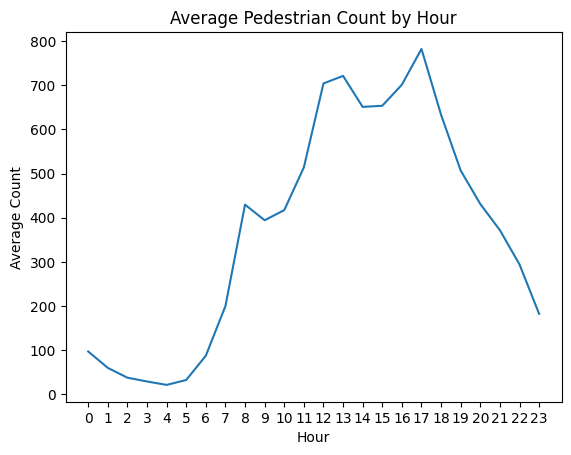

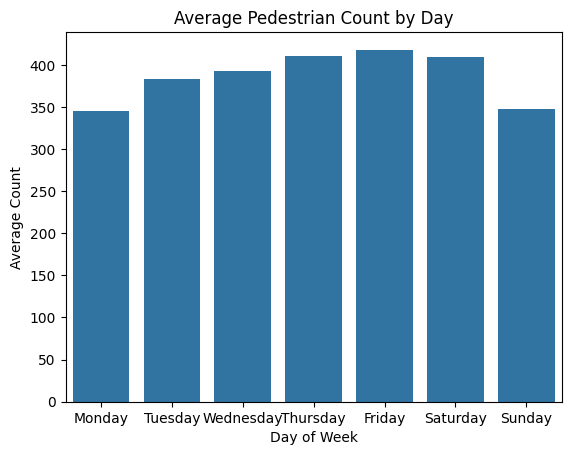

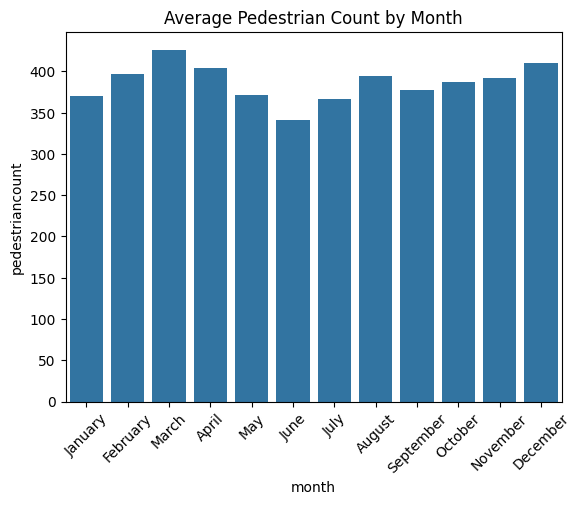

In [19]:
pedestrian_counts_df['sensing_date'] = pd.to_datetime(pedestrian_counts_df['sensing_date'])
pedestrian_counts_df['hour'] = pedestrian_counts_df['hourday'].astype(int)
pedestrian_counts_df['day_of_week'] = pedestrian_counts_df['sensing_date'].dt.day_name()
pedestrian_counts_df['month'] = pedestrian_counts_df['sensing_date'].dt.month_name()

# Hourly trend
hourly_avg = pedestrian_counts_df.groupby('hour')['pedestriancount'].mean().reset_index()
sns.lineplot(data=hourly_avg, x='hour', y='pedestriancount')
plt.title("Average Pedestrian Count by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Count")
plt.xticks(range(0, 24))
plt.show()

# Daily trend
daily_avg = pedestrian_counts_df.groupby('day_of_week')['pedestriancount'].mean().reset_index()
sns.barplot(data=daily_avg, x='day_of_week', y='pedestriancount',order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title("Average Pedestrian Count by Day")
plt.xlabel("Day of Week")
plt.ylabel("Average Count")
plt.show()

# Monthly trend
monthly_avg = pedestrian_counts_df.groupby('month')['pedestriancount'].mean().reset_index()
sns.barplot(data=monthly_avg, x='month', y='pedestriancount',order=['January','February','March','April','May','June','July','August','September','October','November','December'])
plt.title("Average Pedestrian Count by Month")
plt.xticks(rotation=45)
plt.show()

The above plots show clear temporal trends in pedestrian activity across Melbourne. Pedestrian counts peak during morning and evening hours, especially around 8 AM and 5–6 PM, reflecting typical commute times. Daily trends show higher activity from Wednesday to Saturday, with slightly lower counts on Mondays and Sundays. Monthly analysis indicates that March and December experience the highest pedestrian volumes, possibly due to events or seasonal factors, while the lowest counts occur in June and July, aligning with colder winter months.

This code converts the footpaths dataset into a GeoDataFrame by extracting latitude and longitude from geo_point_2d, creating point geometries, and setting the coordinate reference system to EPSG:4326 for spatial analysis.

In [20]:

footpaths_df = footpaths_df.copy()

footpaths_df[['lat', 'lon']] = footpaths_df['geo_point_2d'].str.split(',', expand=True).astype(float)

footpaths_df.dropna(subset=['lat', 'lon'], inplace=True)

footpaths_df['geometry'] = [Point(xy) for xy in zip(footpaths_df['lon'], footpaths_df['lat'])]

footpaths_gdf = gpd.GeoDataFrame(footpaths_df, geometry='geometry')
footpaths_gdf.set_crs(epsg=4326, inplace=True)

print(footpaths_gdf.head(10))




                              geo_point_2d  \
0  -37.815961080824124, 144.98832531320022   
1    -37.8085534639264, 144.97639258466387   
2   -37.82277605089236, 144.93916171174936   
3    -37.82928417509253, 144.9694946357787   
4   -37.791735093497834, 144.9356096446368   
5     -37.81614560851887, 144.958578099413   
6   -37.79704499860942, 144.91945533976192   
7    -37.79864849576223, 144.9265682087075   
8   -37.80998374368285, 144.97348486320715   
9   -37.812019717025734, 144.9711776559789   

                                           geo_shape  prop_id  shape_stle  \
0  {"coordinates": [[[[144.98810598819998, -37.81...        0  105.419673   
1  {"coordinates": [[[[144.9763062409881, -37.808...        0   98.491585   
2  {"coordinates": [[[[144.93917482139165, -37.82...        0    8.048221   
3  {"coordinates": [[[[144.9703584145747, -37.829...        0  263.820023   
4  {"coordinates": [[[[144.93560472908098, -37.79...        0   14.410804   
5  {"coordinates": [[[[144.9584

In this step, we changed the footpaths data to match the map’s coordinate system and plots it on an interactive map with an OpenStreetMap background.

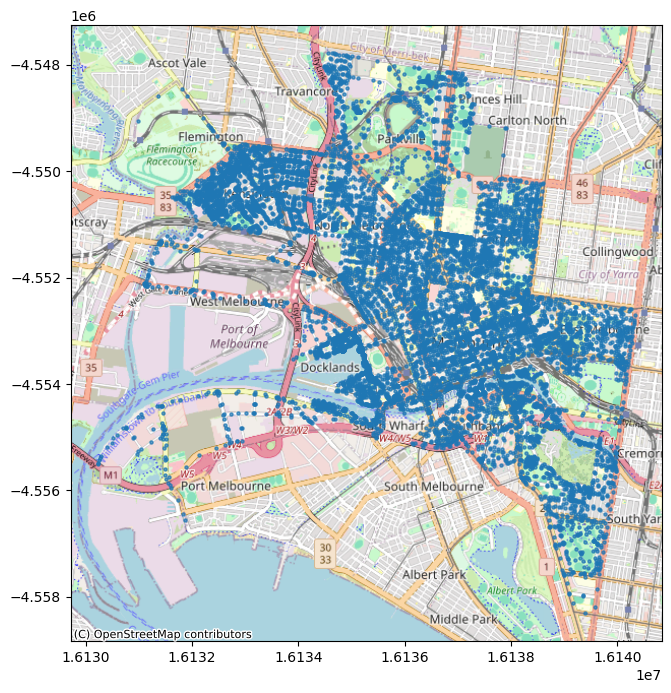

In [21]:

footpaths_gdf = footpaths_gdf.to_crs(epsg=3857)

ax = footpaths_gdf.plot(figsize=(8, 8), markersize=5, alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)


The map shows the distribution of footpaths across central Melbourne, with each blue dot representing a footpath segment. We can observe that footpaths are densely concentrated in the city centre and surrounding areas like Docklands, Carlton, Parkville, and South Melbourne, indicating strong pedestrian infrastructure and high walkability. In contrast, areas on the outskirts, such as West Melbourne, Port Melbourne, and parts of East Melbourne, show noticeably fewer footpath segments, suggesting lower footpath coverage and potentially reduced pedestrian accessibility in those regions.

In this step, I tried to create a heatmap using Folium to show areas with higher footpath density across Melbourne for easy visual analysis.


In [22]:

footpaths_latlon = footpaths_gdf.to_crs(epsg=4326)

m = folium.Map(location=[-37.81, 144.96], zoom_start=13)

heat_data = [[row['lat'], row['lon']] for idx, row in footpaths_latlon.iterrows()]
HeatMap(heat_data).add_to(m)

m


The heatmap shows areas in central Melbourne with high footpath density, where red regions indicate the highest concentration of footpaths. These high-density zones suggest better pedestrian infrastructure and more walkable areas, while outer blue zones represent lower footpath coverage. This aligns with our prior analysis, which also highlighted strong footpath presence in the city centre and reduced coverage in surrounding areas.

In this step, I converted the pedestrian counts data into a GeoDataFrame by extracting coordinates and creating point geometries for spatial analysis.

In [23]:
pedestrian_counts_df[['lat', 'lon']] = pedestrian_counts_df['location'].str.split(',', expand=True)
pedestrian_counts_df['lat'] = pedestrian_counts_df['lat'].astype(float)
pedestrian_counts_df['lon'] = pedestrian_counts_df['lon'].astype(float)

pedestrian_counts_df['geometry'] = pedestrian_counts_df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

pedestrian_gdf = gpd.GeoDataFrame(pedestrian_counts_df, geometry='geometry', crs='EPSG:4326')


This code implements spatial joins to link footpath and pedestrian data with their corresponding localities based on location, enabling suburb-level analysis of footpath availability and pedestrian activity patterns.


In [24]:
localities = localities_df.to_crs(epsg=4326)
footpaths_gdf = footpaths_gdf.to_crs(epsg=4326)
pedestrian_gdf = pedestrian_gdf.to_crs(epsg=4326)

fp_join = gpd.sjoin(footpaths_gdf, localities, how="inner", predicate="within")

pd_join = gpd.sjoin(pedestrian_gdf, localities, how="inner", predicate="within")


In this step, I grouped the footpath data by suburb (gazetted_locality_name) and counted the number of footpath segments in each area to create a footpath_count column for further analysis.

In [25]:
fp_counts = fp_join.groupby('gazetted_locality_name').size().reset_index(name='footpath_count')
fp_counts = fp_counts.sort_values(by='footpath_count', ascending=False)
fp_counts

,gazetted_locality_name,footpath_count
6,MELBOURNE,2626
5,KENSINGTON,1812
2,DOCKLANDS,1694
0,CARLTON,1212
7,NORTH MELBOURNE,1190
8,PARKVILLE,896
3,EAST MELBOURNE,886
15,WEST MELBOURNE,701
14,SOUTHBANK,563
13,SOUTH YARRA,341


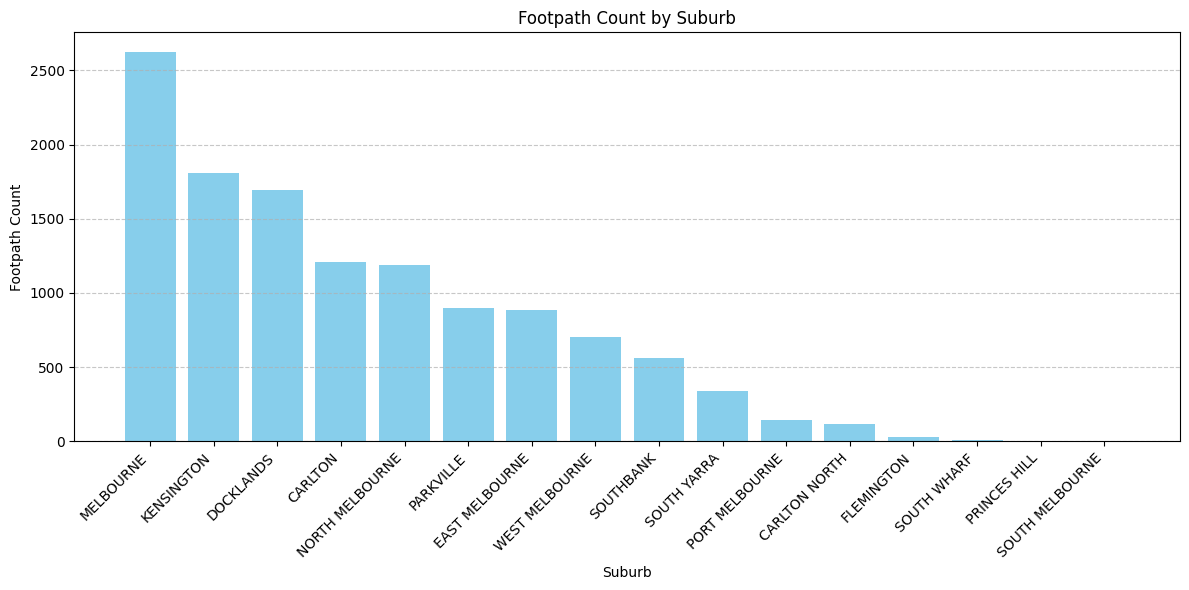

In [26]:
plt.figure(figsize=(12, 6))
plt.bar(fp_counts['gazetted_locality_name'], fp_counts['footpath_count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Suburb')
plt.ylabel('Footpath Count')
plt.title('Footpath Count by Suburb')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The suburb of Melbourne has the highest number of footpath segments (2,626), followed by Kensington (1,812), Docklands (1,694), and Carlton (1,212), indicating strong pedestrian infrastructure in these areas. In contrast, suburbs like South Wharf (6), Princes Hill (2), and South Melbourne (1) show very limited footpath coverage, suggesting lower walkability or less developed infrastructure. This variation highlights the uneven distribution of footpath networks across different parts of the city.

In [27]:
pd_counts = pd_join.groupby('gazetted_locality_name')['hourday'].sum().reset_index(name='pedestrian_count')
pd_counts = pd_counts.sort_values(by='pedestrian_count', ascending=False)
pd_counts

,gazetted_locality_name,pedestrian_count
3,MELBOURNE,10534294
1,DOCKLANDS,2193107
0,CARLTON,875984
7,SOUTHBANK,724892
4,NORTH MELBOURNE,590565
5,PARKVILLE,474461
2,KENSINGTON,426609
8,WEST MELBOURNE,372094
6,SOUTH WHARF,196826


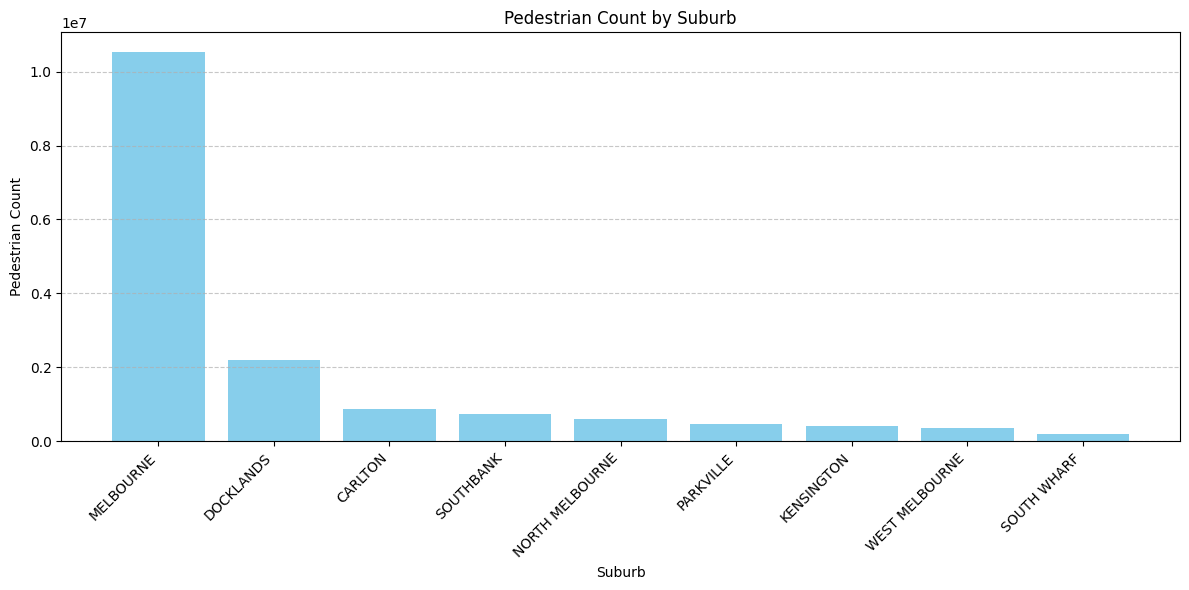

In [28]:
plt.figure(figsize=(12, 6))
plt.bar(pd_counts['gazetted_locality_name'], pd_counts['pedestrian_count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Suburb')
plt.ylabel('Pedestrian Count')
plt.title('Pedestrian Count by Suburb')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The analysis shows that the City of Melbourne recorded a total of over 10.5 million pedestrian counts. Suburbs like Docklands and Carlton have high pedestrian activity, followed closely by Southbank, North Melbourne, and Parkville. In contrast, areas like West Melbourne and South Wharf show comparatively lower foot traffic. These patterns highlight where pedestrian infrastructure is most utilised and can help guide future urban planning and improvements.

In this step, I merged footpath and pedestrian counts by suburb and sorted them to compare areas with the highest pedestrian activity and footpath coverage.

In [29]:
comparison_df = fp_counts.merge(pd_counts, on='gazetted_locality_name')
comparison_df = comparison_df.sort_values(by=['pedestrian_count','footpath_count'], ascending=False)

comparison_df

,gazetted_locality_name,footpath_count,pedestrian_count
0,MELBOURNE,2626,10534294
2,DOCKLANDS,1694,2193107
3,CARLTON,1212,875984
7,SOUTHBANK,563,724892
4,NORTH MELBOURNE,1190,590565
5,PARKVILLE,896,474461
1,KENSINGTON,1812,426609
6,WEST MELBOURNE,701,372094
8,SOUTH WHARF,6,196826


The analysis shows that suburbs like Docklands and Carlton have both high pedestrian activity and good footpath coverage. In contrast, Southbank and South Wharf have high foot traffic but relatively low footpath counts, indicating a need for better pedestrian infrastructure. Kensington and Parkville show strong footpath availability, though pedestrian activity is moderate.

In [30]:
print("Correlation between footpath density and pedestrian activity:")
print(comparison_df['footpath_count'].corr(comparison_df['pedestrian_count']))


Correlation between footpath density and pedestrian activity:
0.7528756184412191


The correlation between footpath density and pedestrian activity is 0.75, indicating a strong positive relationship. This suggests that suburbs with more footpaths generally experience higher pedestrian movement, reinforcing the importance of walkable infrastructure in promoting physical activity.

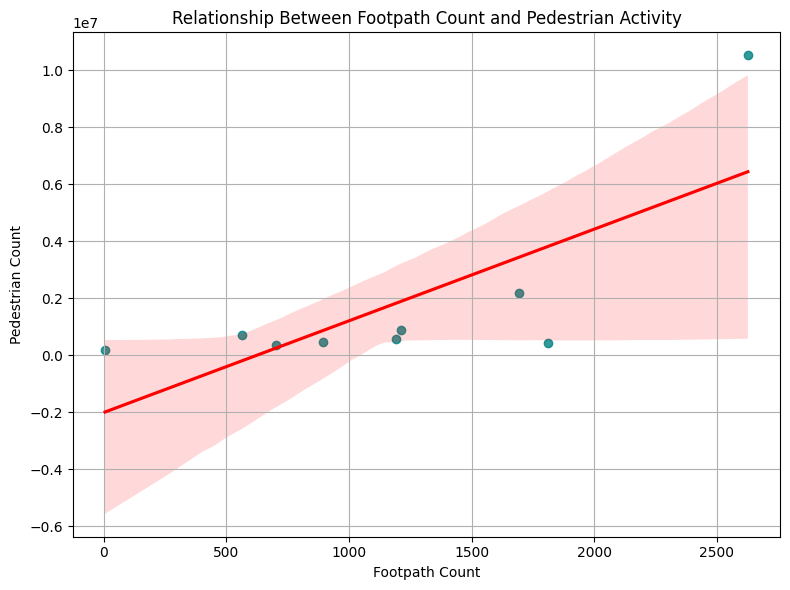

In [31]:

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(data=comparison_df, x='footpath_count', y='pedestrian_count', color='teal', line_kws={"color": "red"})
plt.xlabel('Footpath Count')
plt.ylabel('Pedestrian Count')
plt.title('Relationship Between Footpath Count and Pedestrian Activity')
plt.grid(True)
plt.tight_layout()
plt.show()


This scatter plot with a regression line shows a strong positive relationship between footpath count and pedestrian activity across suburbs. The upward trend indicates that areas with more footpaths tend to have higher pedestrian movement. However, the spread of points also shows variability—some suburbs with high footpath counts have moderate pedestrian use, and vice versa. This suggests that while footpath availability supports walkability, other factors like land use, attractions, and population density may also influence pedestrian activity.

In [33]:
# footpaths per 1000 pedestrians
comparison_df['footpaths_per_1000_peds'] = (comparison_df['footpath_count'] / comparison_df['pedestrian_count']) * 1000
comparison_df_sorted = comparison_df.sort_values(by='footpaths_per_1000_peds', ascending=False)
print(comparison_df_sorted[['gazetted_locality_name', 'footpaths_per_1000_peds']])


  gazetted_locality_name  footpaths_per_1000_peds
1             KENSINGTON                 4.247449
4        NORTH MELBOURNE                 2.015020
5              PARKVILLE                 1.888459
6         WEST MELBOURNE                 1.883933
3                CARLTON                 1.383587
7              SOUTHBANK                 0.776667
2              DOCKLANDS                 0.772420
0              MELBOURNE                 0.249281
8            SOUTH WHARF                 0.030484


This analysis shows the number of footpaths available per 1,000 pedestrians in each suburb, highlighting how well infrastructure supports pedestrian activity relative to demand:

- Kensington has the highest footpath-to-pedestrian ratio (4.25), suggesting strong infrastructure compared to usage.

- North Melbourne, Parkville, and West Melbourne also show good coverage relative to foot traffic.

- In contrast, South Wharf (0.03) and Melbourne CBD (0.25) have very low footpaths per 1,000 pedestrians, indicating potential under-supply of walkable infrastructure in high-demand areas.

- Southbank and Docklands also fall below 1.0, showing that despite high pedestrian activity, footpath availability is relatively limited.

This metric helps pinpoint areas where footpath development may be needed to better support walking activity.